In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp  # the differential equation integrator

plt.rcParams["figure.figsize"] = (12,8)  # make figures big for easier viewing
                                         #    (width, height in inches)
# To revert to the small default size, uncomment the following line
# plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"]


Initial Conditions:

In [3]:
#< Two planets orbiting a star, setting ICs >
g_grav = 1
# Masses
m0 = 2000 ### FIX
m1 = 1 ### FIX
m2 = 0 ### FIX

m_arr = np.array([m0, m1, m2])  # Array of masses to be sent to solve_ivp

# Setting the initial conditions
# Mass 0
r0_0 = np.array([0, 0])  # Position of mass 0
drdt0_0 = np.array([0, 0])  # Velocity of mass 0

# Mass 1

r1_0 = np.array([50, 0])  # still radial
v1 = np.sqrt(g_grav * m0 / np.sqrt(r1_0[0]**2 + r1_0[1]**2)) #--- System kept forcing circular orbit so we had to change velocity term that was forcing it, but failed massively in trying to model for non-closed orbits
drdt1_0 = np.array([0, v1]) 
# Mass 2
r2_0 = np.array([200, 0])  ### FIX Position of mass 2
v2 = np.sqrt(g_grav * m0 / np.sqrt(r2_0[0]**2 + r2_0[1]**2))
drdt2_0 = np.array([0, v2])  ### FIX Velocity of mass 2


r_init = np.concatenate((r0_0, drdt0_0, r1_0, drdt1_0, r2_0, drdt2_0),
                        axis=None)

# Define the time span for the integration
t_span = (0, 2000 * np.pi/v2) ### FIX

Generating plots for position:

In [5]:
#Two planets orbiting a star, Deriv function >

### COPY deriv_2body to here
def deriv_3body_2D(t_now, r_now, m_arr = np.array([1, 1]), epsilon = 0): 
    """ Derivative function for two gravitationally interacting masses.
    r_now is an array ordered (pos_1, vel_1, pos_2, vel_2) where the position
    and velocities may be in 2 or 3 dimensions.
    The optional parameter m_arr contains the masses, while epsilon is the
    gravitational softening"""

    # Determine if this is a two- or three-dimensional problem
    if np.size(r_now) == 12:
        dimension = 2
    elif np.size(r_now) == 18:
        dimension = 3
    else:
        return r_now*0  # If the positions are not in two or three dimensions,
                        #    return a derivative array just filled with zeros

    # Unpack the positions and velocities of the two masses from r_now
    pos_0 = r_now[          0 :   dimension]  # Position of mass 0
    vel_0 = r_now[  dimension : 2*dimension]  # Velocity of mass 0
    pos_1 = r_now[2*dimension : 3*dimension]  # Position of mass 1
    vel_1 = r_now[3*dimension : 4*dimension]  # Velocity of mass 1
    pos_2 = r_now[4*dimension : 5*dimension]  # Position of mass 2
    vel_2 = r_now[5*dimension :            ]  # Velocity of mass 2

    # Derivatives of the positions of the two masses
    dpos_dt_0 = vel_0  
    dpos_dt_1 = vel_1  
    dpos_dt_2 = vel_2

    # Define the relative position
    pos_01 = pos_0 - pos_1 
    pos_02 = pos_0 - pos_2
    pos_12 = pos_1 - pos_2
    # Calculate the distance between the two masses
    dist_01 = np.linalg.norm(pos_01)  # np.linalg.norm returns the magnitude of a
                                    #    vector
    dist_02 = np.linalg.norm(pos_02)
    dist_12 = np.linalg.norm(pos_12)

    # Calculate the magnitude of the two forces/|r|: G m1 m2/(|r| + epsilon)^3
    k_01 = g_grav*m_arr[0]*m_arr[1]/(dist_01 + epsilon)**3
    k_02 = g_grav*m_arr[0]*m_arr[2]/(dist_02 + epsilon)**3
    k_12 = g_grav*m_arr[1]*m_arr[2]/(dist_12 + epsilon)**3

    # Calculate the acceleration of each mass
    acc_0 = (-k_01 * pos_01 + -k_02 * pos_02) / m_arr[0]
    acc_1 = (k_01 * pos_01 + -k_12 * pos_12) / m_arr[1]
    acc_2 = 0*pos_2

    
    print(pos_1,vel_1)

    # Create the array that will hold the derivatives for all elements in r_now
    r_deriv_now = np.concatenate((dpos_dt_0, acc_0, dpos_dt_1, acc_1, dpos_dt_2, acc_2),
                                 axis = None)  # creates a 1-D array by joining
                                               #   the four listed arrays

    return r_deriv_now



In [6]:
#Space Shuttle Orbiting the Star WITHOUT ANY ROCKETS ---- Sanity Test

mass_0 = 1 #2*(10**6) # [kg]; Initial mass of the Space Shuttle
mass_final = 0.1 #10**6 # [kg]; Final mass after fuel in the Space Shuttle Solid Rocket
               #    Booster has been expended

mass_propel = mass_0 - mass_final # [kg]; Mass of propellant contained in
                                  #    Space Shuttle Solid Rocket Booster

burn_time = 120 # [s]; Amount of time before propellant is exhausted from the
              #    first stage boosters.

burn_rate = mass_propel/burn_time # [kg/s]; Rate at which mass is expelled

### COPY deriv_2body to here
def deriv_body_2Drocket(t_now, r_now, m_arr = np.array([1, 1]), epsilon = 0): 
    """ Derivative function for two gravitationally interacting masses.
    r_now is an array ordered (pos_1, vel_1, pos_2, vel_2) where the position
    and velocities may be in 2 or 3 dimensions.
    The optional parameter m_arr contains the masses, while epsilon is the
    gravitational softening"""

    # Determine if this is a two- or three-dimensional problem
    if np.size(r_now) == 13:
        dimension = 2
    elif np.size(r_now) == 19:
        dimension = 3
    else:
        return r_now*0  # If the positions are not in two or three dimensions,
                        #    return a derivative array just filled with zeros

    # Unpack the positions and velocities of the two masses from r_now
    pos_0 = r_now[          0 :   dimension]  # Position of mass 0
    vel_0 = r_now[  dimension : 2*dimension]  # Velocity of mass 0
    pos_1 = r_now[2*dimension : 3*dimension]  # Position of mass 1
    vel_1 = r_now[3*dimension : 4*dimension]  # Velocity of mass 1
    pos_2 = r_now[4*dimension : 5*dimension]  # Position of mass 2
    vel_2 = r_now[5*dimension : -1         ]  # Velocity of mass 2
    mass = r_now [-1]

    if mass > mass_final: 
        dmass_dt = -1*burn_rate
    else:
        dmass_dt = 0
 
    #dvel_dt = (-1*dmass_dt*vel_ex)/mass 
    
    # Derivatives of the positions of the two masses
    dpos_dt_0 = vel_0  ### FIX
    dpos_dt_1 = vel_1  ### FIX
    dpos_dt_2 = vel_2

    # Define the relative position
    pos_01 = pos_0 - pos_1 ### FIX
    pos_02 = pos_0 - pos_2
    pos_12 = pos_1 - pos_2
    # Calculate the distance between the two masses
    dist_01 = np.linalg.norm(pos_01)  # np.linalg.norm returns the magnitude of a
                                    #    vector
    dist_02 = np.linalg.norm(pos_02)
    dist_12 = np.linalg.norm(pos_12)

    # Calculate the magnitude of the two forces/|r|: G m1 m2/(|r| + epsilon)^3
    k_01 = g_grav*m_arr[0]*mass/(dist_01 + epsilon)**3
    k_02 = g_grav*m_arr[0]*m_arr[2]/(dist_02 + epsilon)**3
    k_12 = g_grav*mass*m_arr[2]/(dist_12 + epsilon)**3

    # Calculate the acceleration of each mass
    acc_0 = (-k_01 * pos_01 + -k_02 * pos_02) / m_arr[0]
    acc_1 = (k_01 * pos_01 + -k_12 * pos_12) / mass
    acc_2 = 0*pos_2

    #print(r_now)
    #print(pos_1, vel_1)

    # Create the array that will hold the derivatives for all elements in r_now
    r_deriv_now = np.concatenate((dpos_dt_0, acc_0, dpos_dt_1, acc_1, dpos_dt_2, acc_2, np.array(dmass_dt)),
                                 axis = None)  # creates a 1-D array by joining
                                               #   the four listed arrays
    return r_deriv_now


Plots:

<function matplotlib.pyplot.show(close=None, block=None)>

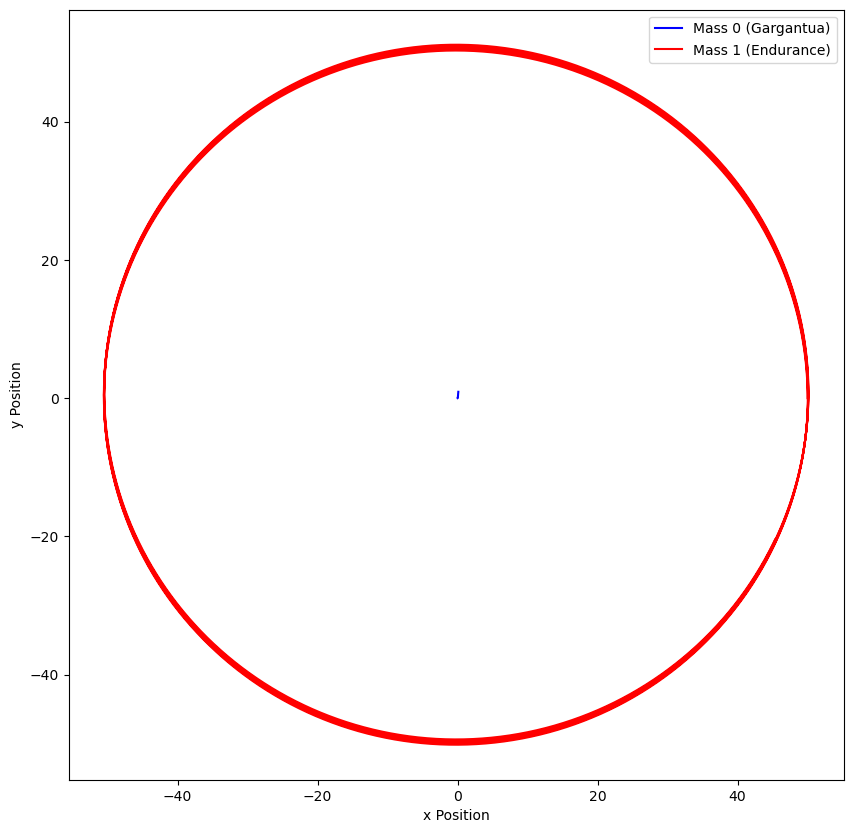

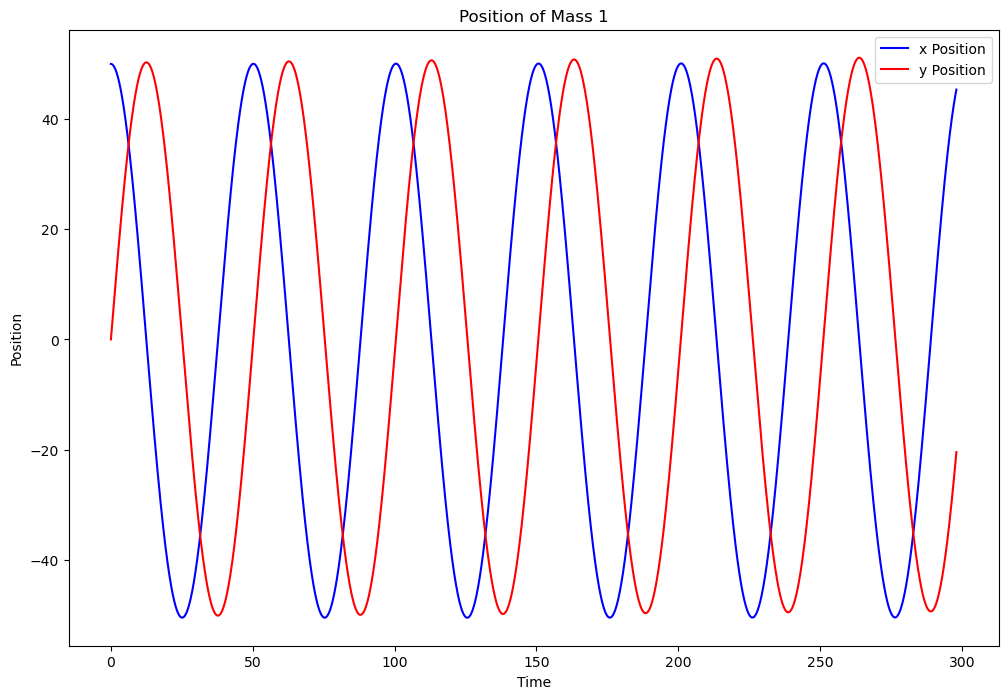

In [8]:
# < Two planets orbiting a star, Plots >
epsilon = 0.1 
# Epsilon different from eccentricity. Epsilon makes sure /0 doesn't occur in deriv_3body

r_init = np.concatenate((r0_0, drdt0_0, r1_0, drdt1_0, r2_0, drdt2_0, mass_0),
                        axis=None)
t_arr = np.linspace(0, 300 * np.pi/v2, 10000)
### USE solve_ivp to integrate for the solution
r_soln = solve_ivp(deriv_body_2Drocket, t_span, r_init, args = (m_arr, epsilon),
                   t_eval = t_arr, max_step = 0.1)

#r_soln = solve_ivp(deriv_3body_2D, t_span, r_init[:-1], args = (m_arr, epsilon),
#                   t_eval = t_arr, max_step = 0.1)

### PLOT the trajectory for both masses
x_0 = r_soln.y[0]
y_0 = r_soln.y[1]
x_1 = r_soln.y[4]
y_1 = r_soln.y[5]

fig, ax = plt.subplots(figsize=(10, 10))
ax.plot(x_0, y_0, color="blue")
ax.plot(x_1, y_1, color="red")

ax.legend(['Mass 0 (Gargantua)', 'Mass 1 (Endurance)', 'Mass 2 (planet)'])
ax.set_xlabel('x Position')
ax.set_ylabel('y Position')
plt.show

### PLOT x and y vs. t for m1
fig, ax = plt.subplots()
ax.plot(r_soln.t, x_1, color="blue")
ax.set_xlabel('Time')
ax.set_ylabel('Position')
ax.plot(r_soln.t, y_1, color="red")
ax.legend(['x Position', 'y Position'])
ax.set_title('Position of Mass 1')
plt.show


Solve for eccentricity of orbit:

In [10]:
# Another sanity test - eccentricity should be very very close to 0
mu = m0*m1/(m0+m1)
l = np.average(mu*((x_1**2 + y_1**2))*(np.sqrt(r_soln.y[6]**2 + r_soln.y[7]**2)/np.sqrt(x_1**2 + y_1**2)))
c = l**2/(g_grav*m0*m1*mu)
r_min = min(np.sqrt(x_1**2 + y_1**2))
r_max = max(np.sqrt(x_1**2 + y_1**2))
e = (c/r_min) - 1

print(np.sqrt(x_1**2 + y_1**2))
#print(l)
print(c)
print(r_min)
print(e)

#ALL OF THIS OCCURS JUST AS WE EXPECT

[50.         50.00000212 50.00000849 ... 49.7405731  49.743491
 49.74641731]
49.902449264535264
49.3589367277984
0.011011431217292866


In [11]:
# Getting to our actual experiment - checking independent vs. dependent variables

# Setting our independent variable
vel_ex = -2.0 # in m/s

In [12]:
#Two planets orbiting a star, Deriv function ---- Adding thrust 

mass_0 = 1 #2*(10**6) # [kg]; Initial mass of the Space Shuttle
mass_final = 0.1 #10**6 # [kg]; Final mass after fuel in the Space Shuttle Solid Rocket
               #    Booster has been expended

mass_propel = mass_0 - mass_final # [kg]; Mass of propellant contained in
                                  #    Space Shuttle Solid Rocket Booster

burn_time = 30 # [s]; Amount of time before propellant is exhausted from the
              #    first stage boosters.

burn_rate = mass_propel/burn_time # [kg/s]; Rate at which mass is expelled

### COPY deriv_2body to here
def deriv_body_2Drocket(t_now, r_now, m_arr = np.array([1, 1]), epsilon = 0): 
    """ Derivative function for two gravitationally interacting masses.
    r_now is an array ordered (pos_1, vel_1, pos_2, vel_2) where the position
    and velocities may be in 2 or 3 dimensions.
    The optional parameter m_arr contains the masses, while epsilon is the
    gravitational softening"""

    # Determine if this is a two- or three-dimensional problem
    if np.size(r_now) == 13:
        dimension = 2
    elif np.size(r_now) == 19:
        dimension = 3
    else:
        return r_now*0  # If the positions are not in two or three dimensions,
                        #    return a derivative array just filled with zeros

    # Unpack the positions and velocities of the two masses from r_now
    pos_0 = r_now[          0 :   dimension]  # Position of mass 0
    vel_0 = r_now[  dimension : 2*dimension]  # Velocity of mass 0
    pos_1 = r_now[2*dimension : 3*dimension]  # Position of mass 1
    vel_1 = r_now[3*dimension : 4*dimension]  # Velocity of mass 1
    pos_2 = r_now[4*dimension : 5*dimension]  # Position of mass 2
    vel_2 = r_now[5*dimension : -1         ]  # Velocity of mass 2
    mass = r_now [-1]

  # After reading on a large number of forums we decided this would not work for a large vel_ex as the strict cutoff was causing exorbitant run times
    if mass > mass_final + 1e-6: 
        dmass_dt = -1*burn_rate
    else:
        dmass_dt = 0


 
    #dvel_dt = (-1*dmass_dt*vel_ex)/mass 
    
    # Derivatives of the positions of the two masses
    dpos_dt_0 = vel_0  ### FIX
    dpos_dt_1 = vel_1  ### FIX
    dpos_dt_2 = vel_2

    # Define the relative position
    pos_01 = pos_0 - pos_1 ### FIX
    pos_02 = pos_0 - pos_2
    pos_12 = pos_1 - pos_2
    # Calculate the distance between the two masses
    dist_01 = np.linalg.norm(pos_01)  # np.linalg.norm returns the magnitude of a
                                    #    vector
    dist_02 = np.linalg.norm(pos_02)
    dist_12 = np.linalg.norm(pos_12)

    # Calculate the magnitude of the two forces/|r|: G m1 m2/(|r| + epsilon)^3
    k_01 = g_grav*m_arr[0]*mass/(dist_01 + epsilon)**3
    k_02 = g_grav*m_arr[0]*m_arr[2]/(dist_02 + epsilon)**3
    k_12 = g_grav*mass*m_arr[2]/(dist_12 + epsilon)**3

    vx = vel_1[0]
    vy = vel_1[1]
    vel_nowsq = vx**2 + vy**2
    vel_mag = np.sqrt(vel_nowsq)

    # Calculate the acceleration of each mass INCLUDING OUR THRUST TERM
    acc_0 = (-k_01 * pos_01 + -k_02 * pos_02) / m_arr[0]
    thrust = (dmass_dt*vel_ex *(vel_1/vel_mag))
    acc_1 = thrust + (k_01 * pos_01 + -k_12 * pos_12) / mass
    acc_2 = 0*pos_2

    #print(r_now)
    #print(pos_1, vel_1)

    # Create the array that will hold the derivatives for all elements in r_now
    r_deriv_now = np.concatenate((dpos_dt_0, acc_0, dpos_dt_1, acc_1, dpos_dt_2, acc_2, np.array(dmass_dt)),
                                 axis = None)  # creates a 1-D array by joining
                                               #   the four listed arrays
    return r_deriv_now


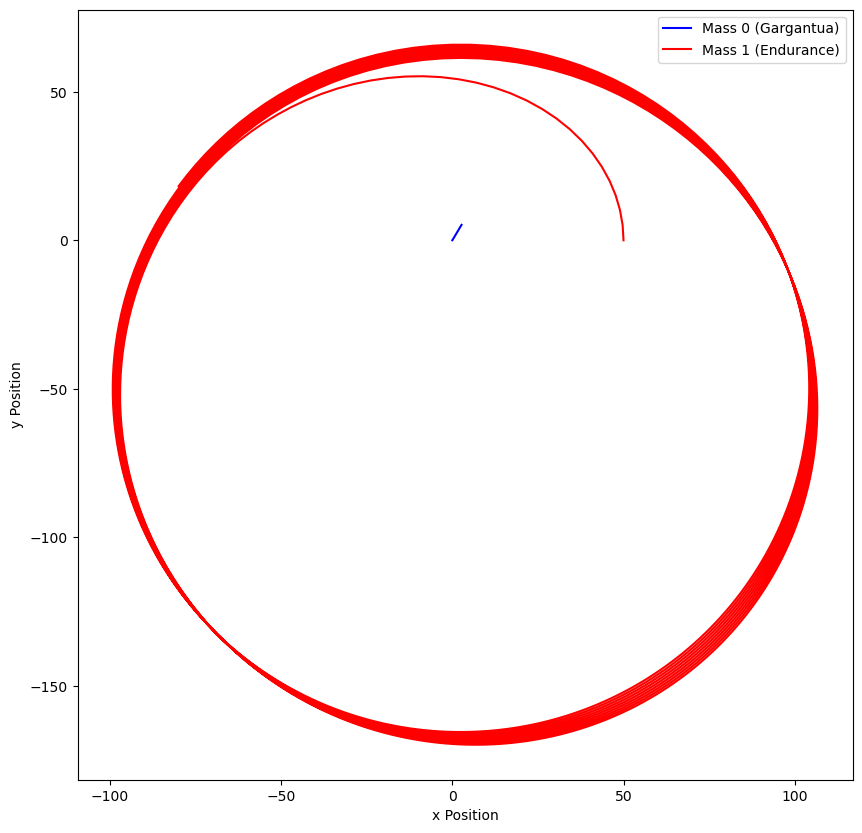

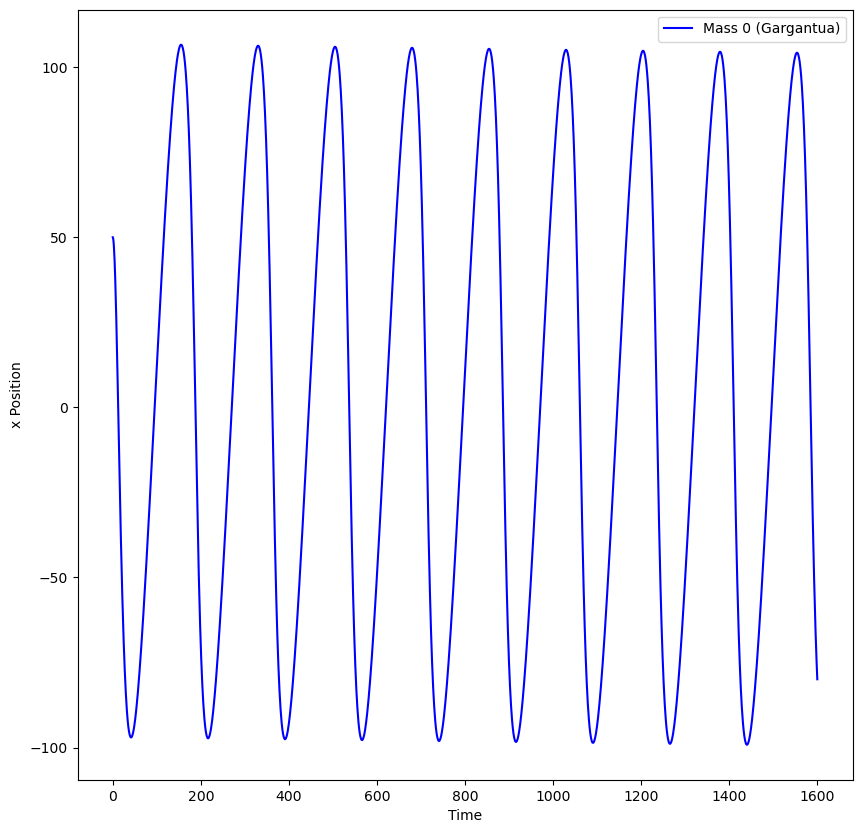

In [13]:
# < Endurance orbiting Gargantua ---- PLOTS
epsilon = 0.1 

# PERSONAL NOTES: Epsilon different from eccentricity. Epsilon makes sure /0 doesn't occur in deriv_3body

r_init = np.concatenate((r0_0, drdt0_0, r1_0, drdt1_0, r2_0, drdt2_0, mass_0),
                        axis=None)
t_arr = np.linspace(0, 1600, 2000)
### USE solve_ivp to integrate for the solution
r_soln = solve_ivp(deriv_body_2Drocket, t_span, r_init, args = (m_arr, epsilon),
                   t_eval = t_arr, max_step = 0.1, method='Radau')

#r_soln = solve_ivp(deriv_3body_2D, t_span, r_init[:-1], args = (m_arr, epsilon),
#                   t_eval = t_arr, max_step = 0.1)

### PLOT the trajectory for both masses
x_0 = r_soln.y[0]
y_0 = r_soln.y[1]
x_1 = r_soln.y[4]
y_1 = r_soln.y[5]

fig, ax = plt.subplots(figsize=(10, 10))
ax.plot(x_0, y_0, color="blue")
ax.plot(x_1, y_1, color="red")

ax.legend(['Mass 0 (Gargantua)', 'Mass 1 (Endurance)', 'Mass 2 (planet)'])
ax.set_xlabel('x Position')
ax.set_ylabel('y Position')
plt.show()

fig, ax = plt.subplots(figsize=(10, 10))
ax.plot(r_soln.t, x_1, color="blue")

ax.legend(['Mass 0 (Gargantua)', 'Mass 1 (Endurance)', 'Mass 2 (planet)'])
ax.set_xlabel('Time')
ax.set_ylabel('x Position')
plt.show()

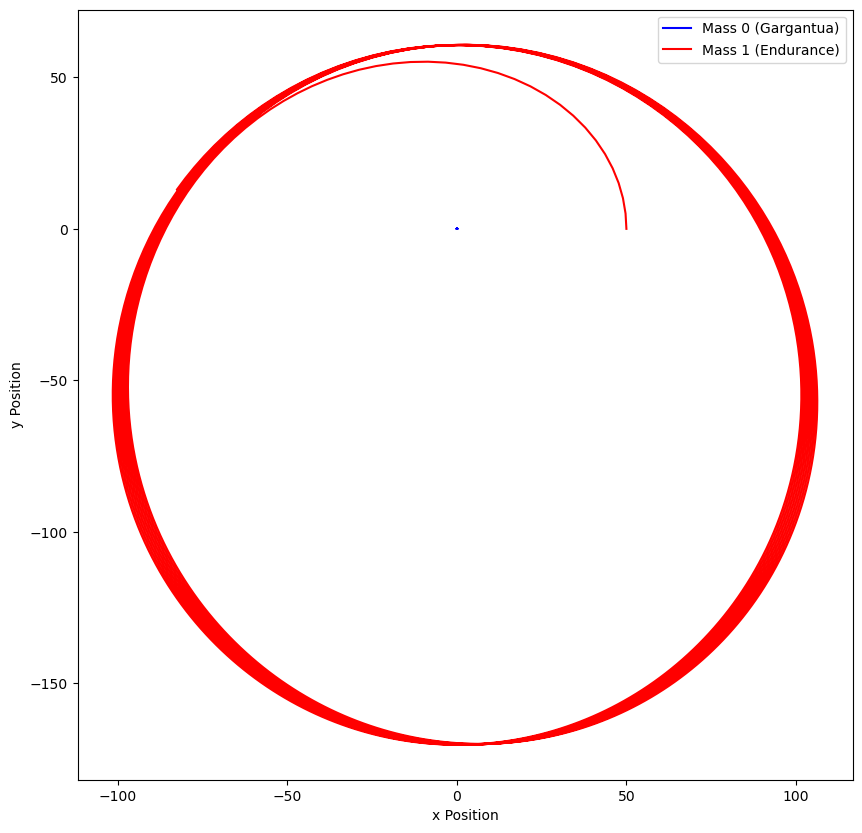

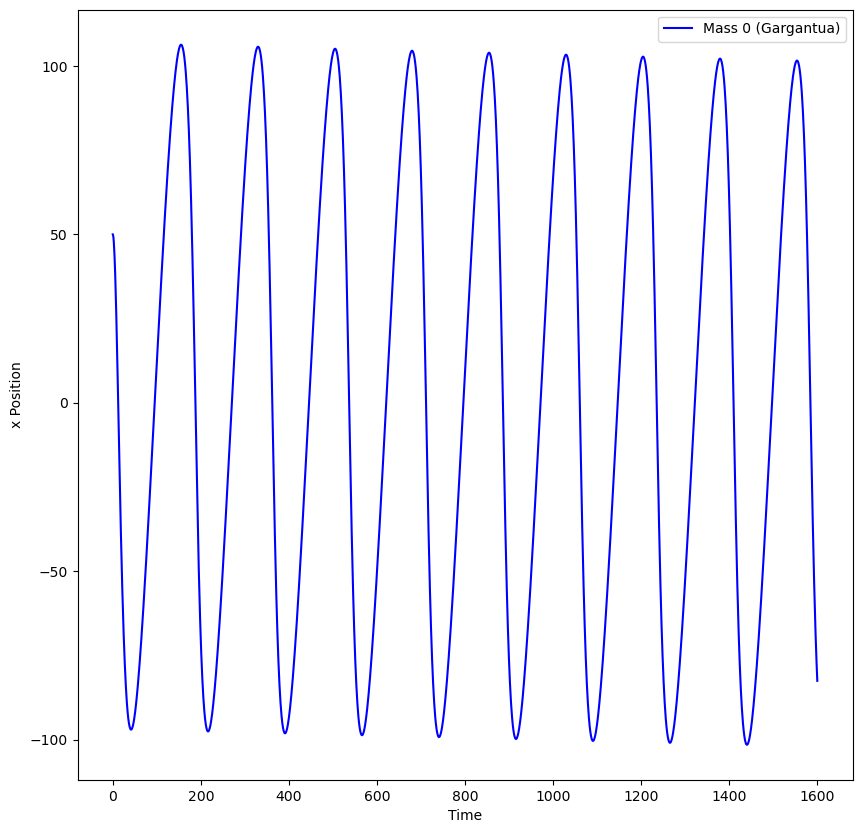

In [14]:
# Plotting in COM frame
### USE the guidance above to create arrays of the center of mass of the system
#    at each time step

x_com = np.column_stack((r_soln.y[0], r_soln.y[4], r_soln.y[8]))
x_com = np.transpose(x_com)
x_com = np.matmul(m_arr, x_com) / np.sum(m_arr)
y_com = np.column_stack((r_soln.y[1], r_soln.y[5], r_soln.y[9]))
y_com = np.transpose(y_com)
y_com = np.matmul(m_arr, y_com) / np.sum(m_arr)

### PLOT the trajectories of all masses in COM frame
x_0 = r_soln.y[0] - x_com
y_0 = r_soln.y[1] - y_com
x_1 = r_soln.y[4] - x_com
y_1 = r_soln.y[5] - y_com
x_2 = r_soln.y[8] - x_com
y_2 = r_soln.y[9] - y_com

fig, ax = plt.subplots(figsize=(10, 10))
ax.plot(x_0, y_0, color="blue")
ax.plot(x_1, y_1, color="red")

ax.legend(['Mass 0 (Gargantua)', 'Mass 1 (Endurance)', 'Mass 2 (planet)'])
ax.set_xlabel('x Position')
ax.set_ylabel('y Position')
plt.show()

fig, ax = plt.subplots(figsize=(10, 10))
ax.plot(r_soln.t, x_1, color="blue")

ax.legend(['Mass 0 (Gargantua)', 'Mass 1 (Endurance)', 'Mass 2 (planet)'])
ax.set_xlabel('Time')
ax.set_ylabel('x Position')
plt.show()

In [15]:
# Getting to our actual experiment - checking independent vs. dependent variables - CODE REPEATED FOR EASE OF PLUG AND CHUG

# Setting our independent variable
vel_ex = -4.0 # in m/s

In [16]:
#Two planets orbiting a star, Deriv function ---- Adding thrust - CODE REPEATED FOR EASE OF PLUG AND CHUG

mass_0 = 1 #2*(10**6) # [kg]; Initial mass of the Space Shuttle
mass_final = 0.1 #10**6 # [kg]; Final mass after fuel in the Space Shuttle Solid Rocket
               #    Booster has been expended

mass_propel = mass_0 - mass_final # [kg]; Mass of propellant contained in
                                  #    Space Shuttle Solid Rocket Booster

burn_time = 30 # [s]; Amount of time before propellant is exhausted from the
              #    first stage boosters.

burn_rate = mass_propel/burn_time # [kg/s]; Rate at which mass is expelled

### COPY deriv_2body to here
def deriv_body_2Drocket(t_now, r_now, m_arr = np.array([1, 1]), epsilon = 0): 
    """ Derivative function for two gravitationally interacting masses.
    r_now is an array ordered (pos_1, vel_1, pos_2, vel_2) where the position
    and velocities may be in 2 or 3 dimensions.
    The optional parameter m_arr contains the masses, while epsilon is the
    gravitational softening"""

    # Determine if this is a two- or three-dimensional problem
    if np.size(r_now) == 13:
        dimension = 2
    elif np.size(r_now) == 19:
        dimension = 3
    else:
        return r_now*0  # If the positions are not in two or three dimensions,
                        #    return a derivative array just filled with zeros

    # Unpack the positions and velocities of the two masses from r_now
    pos_0 = r_now[          0 :   dimension]  # Position of mass 0
    vel_0 = r_now[  dimension : 2*dimension]  # Velocity of mass 0
    pos_1 = r_now[2*dimension : 3*dimension]  # Position of mass 1
    vel_1 = r_now[3*dimension : 4*dimension]  # Velocity of mass 1
    pos_2 = r_now[4*dimension : 5*dimension]  # Position of mass 2
    vel_2 = r_now[5*dimension : -1         ]  # Velocity of mass 2
    mass = r_now [-1]

  # After reading on a large number of forums we decided this would not work for a large vel_ex as the strict cutoff was causing exorbitant run times
    if mass > mass_final + 1e-6: 
        dmass_dt = -1*burn_rate
    else:
        dmass_dt = 0


 
    #dvel_dt = (-1*dmass_dt*vel_ex)/mass 
    
    # Derivatives of the positions of the two masses
    dpos_dt_0 = vel_0  ### FIX
    dpos_dt_1 = vel_1  ### FIX
    dpos_dt_2 = vel_2

    # Define the relative position
    pos_01 = pos_0 - pos_1 ### FIX
    pos_02 = pos_0 - pos_2
    pos_12 = pos_1 - pos_2
    # Calculate the distance between the two masses
    dist_01 = np.linalg.norm(pos_01)  # np.linalg.norm returns the magnitude of a
                                    #    vector
    dist_02 = np.linalg.norm(pos_02)
    dist_12 = np.linalg.norm(pos_12)

    # Calculate the magnitude of the two forces/|r|: G m1 m2/(|r| + epsilon)^3
    k_01 = g_grav*m_arr[0]*mass/(dist_01 + epsilon)**3
    k_02 = g_grav*m_arr[0]*m_arr[2]/(dist_02 + epsilon)**3
    k_12 = g_grav*mass*m_arr[2]/(dist_12 + epsilon)**3

    vx = vel_1[0]
    vy = vel_1[1]
    vel_nowsq = vx**2 + vy**2
    vel_mag = np.sqrt(vel_nowsq)

    # Calculate the acceleration of each mass INCLUDING OUR THRUST TERM
    acc_0 = (-k_01 * pos_01 + -k_02 * pos_02) / m_arr[0]
    thrust = (dmass_dt*vel_ex *(vel_1/vel_mag))
    acc_1 = thrust + (k_01 * pos_01 + -k_12 * pos_12) / mass
    acc_2 = 0*pos_2

    #print(r_now)
    #print(pos_1, vel_1)

    # Create the array that will hold the derivatives for all elements in r_now
    r_deriv_now = np.concatenate((dpos_dt_0, acc_0, dpos_dt_1, acc_1, dpos_dt_2, acc_2, np.array(dmass_dt)),
                                 axis = None)  # creates a 1-D array by joining
                                               #   the four listed arrays
    return r_deriv_now
#------------------------------------------------------------------------------------------------------------------------------------------------
# Finding the value of our dependent variable - CODE REPEATED FOR EASE OF PLUG AND CHUG

# < Endurance orbiting Gargantua ---- PLOTS
epsilon = 0.1 

# PERSONAL NOTES: Epsilon different from eccentricity. Epsilon makes sure /0 doesn't occur in deriv_3body

r_init = np.concatenate((r0_0, drdt0_0, r1_0, drdt1_0, r2_0, drdt2_0, mass_0),
                        axis=None)
t_arr = np.linspace(0, 1600, 2000)
### USE solve_ivp to integrate for the solution
r_soln = solve_ivp(deriv_body_2Drocket, t_span, r_init, args = (m_arr, epsilon),
                   t_eval = t_arr, max_step = 0.1, method='Radau')

#r_soln = solve_ivp(deriv_3body_2D, t_span, r_init[:-1], args = (m_arr, epsilon),
#                   t_eval = t_arr, max_step = 0.1)

### PLOT the trajectory for both masses
x_0 = r_soln.y[0]
y_0 = r_soln.y[1]
x_1 = r_soln.y[4]
y_1 = r_soln.y[5]


In [17]:
#Calculating eccentricities for analysis purposes - CODE REPEATED FOR EASE OF PLUG AND CHUG
mu = m0*m1/(m0+m1)
x_1f = x_1[r_soln.t > 30] #This is x_1 but ONLY after the first 30 seconds
y_1f = y_1[r_soln.t > 30] ##This is y_1 but ONLY after the first 30 seconds 

l = np.average(mu*((x_1f**2 + y_1f**2))*(np.sqrt(r_soln.y[6][r_soln.t > 30]**2 + r_soln.y[7][r_soln.t > 30]**2)/np.sqrt(x_1f**2 + y_1f**2)))
c = l**2/(g_grav*m0*m1*mu)
r_min = min(np.sqrt(x_1f**2 + y_1f**2))
r_max = max(np.sqrt(x_1f**2 + y_1f**2))

e_min = (c/r_min) - 1
e_max = 1 - (c/r_max)

e_real = (e_min + e_max)/2

print(e_real)

print(r_max)

152.00779764141475
5212.6717861801935


In [18]:
# Checking that energy is conserved
gamma = g_grav*m0*m1
E = (((gamma**2)*mu)/(2*l))*((e_real**2) - 1)
print(E)

5325459.317460491
